In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns

from datetime import datetime

import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing

np.random.seed(42)

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
def get_saas_data():
    df = pd.read_csv('saas.csv' )
    return df

In [3]:
# get data
df = get_saas_data()

# peak into data
df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [4]:
# check data types
df.dtypes

Month_Invoiced        object
Customer_Id            int64
Invoice_Id             int64
Subscription_Type    float64
Amount               float64
dtype: object

In [5]:
# convert data type; from object to datetime
df['Month_Invoiced'] = pd.to_datetime(df['Month_Invoiced'])

In [6]:
# check data types to see conversion of Month_invoiced data type from object to datetime
df.dtypes

Month_Invoiced       datetime64[ns]
Customer_Id                   int64
Invoice_Id                    int64
Subscription_Type           float64
Amount                      float64
dtype: object

In [7]:
# set date to index
df = df.set_index('Month_Invoiced').sort_index()

# peak into data
df

,Customer_Id,Invoice_Id,Subscription_Type,Amount
Month_Invoiced,,,,
2014-01-31,1000000,5000000,0.0,0.0
2014-01-31,1000001,5000001,2.0,10.0
2014-01-31,1000002,5000002,0.0,0.0
2014-01-31,1000003,5000003,0.0,0.0
2014-01-31,1000004,5000004,1.0,5.0
...,...,...,...,...
2017-12-31,1029395,5790453,0.0,0.0
2017-12-31,1029396,5790454,0.0,0.0
2017-12-31,1029397,5790455,3.0,15.0


In [8]:
# df_resampled = df['Amount'].resample('Y').sum()
# df_resampled.head()

In [9]:
# resample dataframe to a month time period
df_resampled = df.resample('M')[['Amount']].sum()

# peak into data
df_resampled.head()

,Amount
Month_Invoiced,
2014-01-31,35850.0
2014-02-28,37190.0
2014-03-31,38295.0
2014-04-30,39255.0
2014-05-31,40355.0


In [10]:
# get length of dataframe
df_resampled.shape

(48, 1)

In [11]:
# set train to 50% of total
train_size = int(round(df_resampled.shape[0]* 0.5))
train_size

24

In [12]:
# set validate to 30% of total
validate_size = int(round(df_resampled.shape[0]* 0.3))
validate_size

14

In [13]:
# set test to to remaining of total which is 20 %
test_size = int(round(df_resampled.shape[0]* 0.2))
test_size

10

In [14]:
# validate will go from train_size + validate size
validate_end_index = train_size + validate_size
validate_end_index

38

In [15]:
# split into train, validate, test
train = df_resampled[:train_size]
validate = df_resampled[train_size:validate_end_index]
test = df_resampled[validate_end_index:]

#### check gap between train, validate and test

In [16]:
train.tail()

,Amount
Month_Invoiced,
2015-08-31,50495.0
2015-09-30,50985.0
2015-10-31,51445.0
2015-11-30,51260.0
2015-12-31,51505.0


In [17]:
validate.head()

,Amount
Month_Invoiced,
2016-01-31,51955.0
2016-02-29,51955.0
2016-03-31,52000.0
2016-04-30,52190.0
2016-05-31,52325.0


In [18]:
validate.tail()

,Amount
Month_Invoiced,
2016-10-31,53190.0
2016-11-30,53375.0
2016-12-31,53320.0
2017-01-31,53395.0
2017-02-28,53440.0


In [19]:
test.head()

,Amount
Month_Invoiced,
2017-03-31,53480.0
2017-04-30,53350.0
2017-05-31,53340.0
2017-06-30,53405.0
2017-07-31,53680.0


#### Verify splits

In [20]:
# check if length of sum of each splited dataframe equals to length of the original dataframe
len(df_resampled) == len(train) + len(validate) + len(test)

True

In [21]:
pd.concat([train.head(1), df_resampled.head(1)])

,Amount
Month_Invoiced,
2014-01-31,35850.0
2014-01-31,35850.0


In [22]:
pd.concat([test.tail(1), df_resampled.tail(1)])

,Amount
Month_Invoiced,
2017-12-31,53805.0
2017-12-31,53805.0


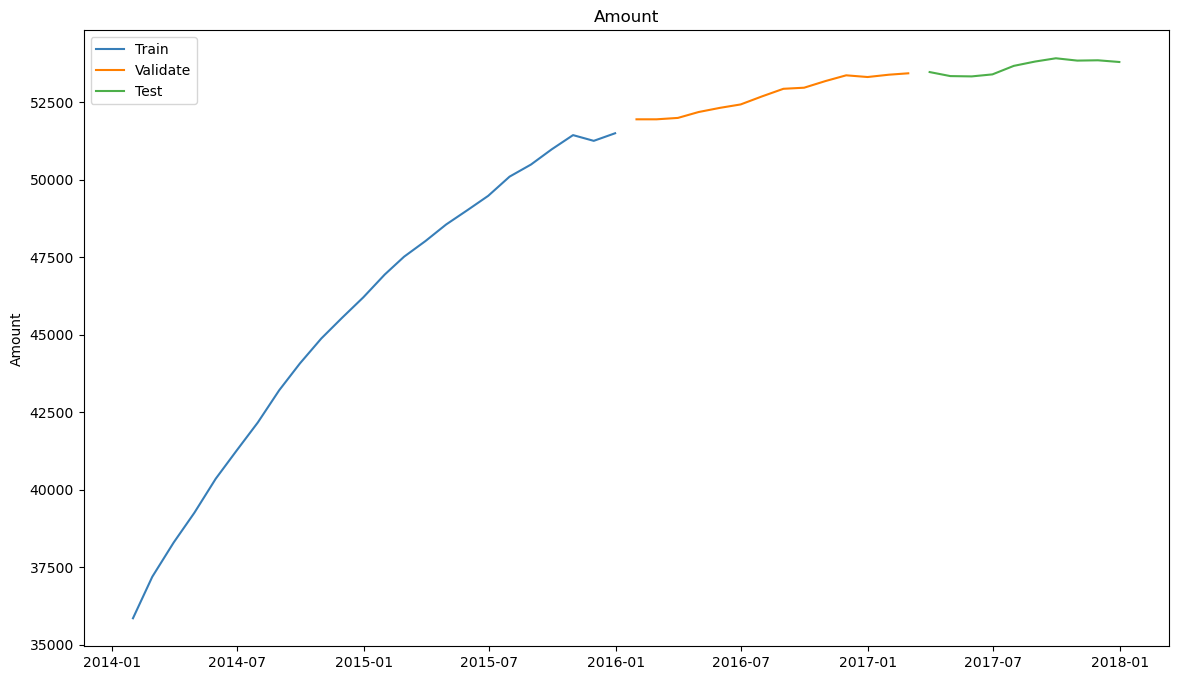

In [23]:
for col in train.columns:
    plt.figure(figsize=(14,8))
    plt.plot(train[col], color='#377eb8', label = 'Train')
    plt.plot(validate[col], color='#ff7f00', label = 'Validate')
    plt.plot(test[col], color='#4daf4a', label = 'Test')
    plt.legend()
    plt.ylabel(col)
    plt.title(col)
    plt.show()

#### Simple Average

In [24]:
avg_amount = round(train['Amount'].mean(),2)
avg_amount

45568.54

In [25]:
def make_baseline_predictions(amount):
    yhat_df = pd.DataFrame({'Amount': amount},
                          index=validate.index)
    return yhat_df

In [26]:
yhat_df = make_baseline_predictions(avg_amount)
yhat_df.head()

,Amount
Month_Invoiced,
2016-01-31,45568.54
2016-02-29,45568.54
2016-03-31,45568.54
2016-04-30,45568.54
2016-05-31,45568.54


In [27]:
def plot_and_eval(target_var, model_type):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1, color='#377eb8')
    plt.plot(validate[target_var], label='Validate', linewidth=1, color='#ff7f00')
    plt.plot(yhat_df[target_var], label='yhat', linewidth=2, color='#a65628')
    plt.legend()
    plt.title(target_var)
    rmse = round(mean_squared_error(validate[target_var], yhat_df[target_var], squared=False), 0)
    df = pd.DataFrame({'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]})
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()
    return df

Amount -- RMSE: 7181


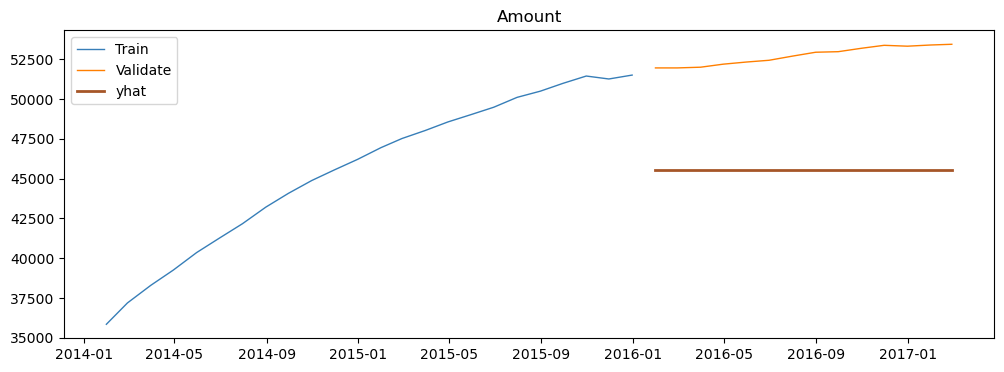

In [28]:
df_model = plot_and_eval('Amount', 'Simple Average')
df_rmse_model = df_model

#### Moving Average

In [29]:
period=7
train['Amount'].rolling(period).mean()

Month_Invoiced
2014-01-31             NaN
2014-02-28             NaN
2014-03-31             NaN
2014-04-30             NaN
2014-05-31             NaN
2014-06-30             NaN
2014-07-31    39195.714286
2014-08-31    40247.142857
2014-09-30    41230.714286
2014-10-31    42171.428571
2014-11-30    43070.000000
2014-12-31    43906.428571
2015-01-31    44719.285714
2015-02-28    45483.571429
2015-03-31    46171.428571
2015-04-30    46812.142857
2015-05-31    47404.285714
2015-06-30    47967.142857
2015-07-31    48523.571429
2015-08-31    49030.714286
2015-09-30    49525.714286
2015-10-31    50014.285714
2015-11-30    50400.000000
2015-12-31    50754.285714
Freq: M, Name: Amount, dtype: float64

In [30]:
train['Amount'].rolling(period).mean()[-1]

50754.28571428572

In [31]:
rolling_amount = round(train['Amount'].rolling(period).mean()[-1],2)
rolling_amount

50754.29

In [32]:
yhat_df = make_baseline_predictions(rolling_amount)
yhat_df.head()

,Amount
Month_Invoiced,
2016-01-31,50754.29
2016-02-29,50754.29
2016-03-31,50754.29
2016-04-30,50754.29
2016-05-31,50754.29


Amount -- RMSE: 2050


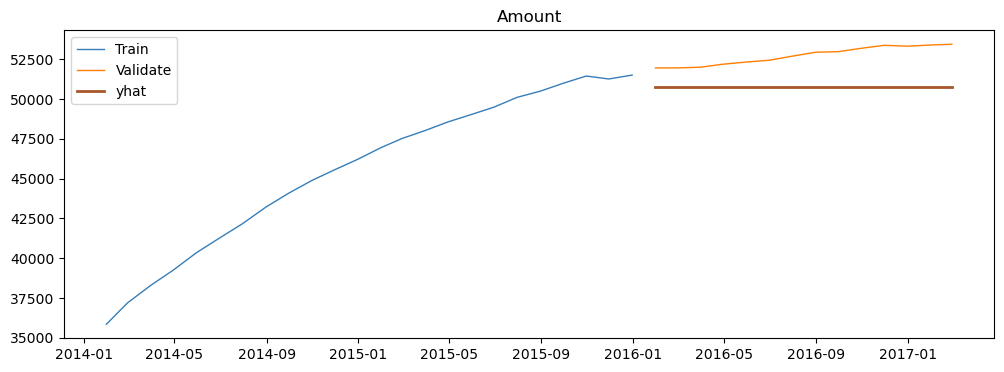

In [33]:
df_model = plot_and_eval('Amount', '7_days_movine_avg')
df_rmse_model = pd.concat([df_rmse_model,df_model],ignore_index=True)

#### Holt's Linear Trend Model

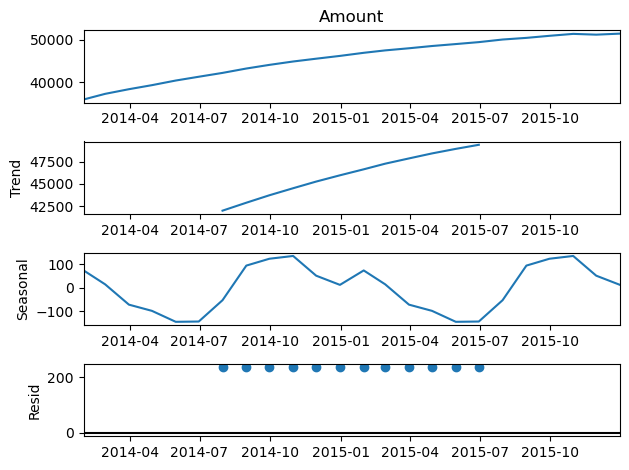

In [34]:
for col in train.columns:
    sm.tsa.seasonal_decompose(train[col].resample('M').mean()).plot()

In [35]:
col = 'Amount' 
# create our Holt Object
model = Holt(train[col], exponential=False, damped=True)
# fit the Holt object
model = model.fit(optimized=True)
yhat_values = model.predict(start = validate.index[0],
                              end = validate.index[-1])
yhat_df[col] = round(yhat_values, 2)
yhat_df.head()

,Amount
Month_Invoiced,
2016-01-31,51748.62
2016-02-29,51962.00
2016-03-31,52173.35
2016-04-30,52382.69
2016-05-31,52590.04


Amount -- RMSE: 456


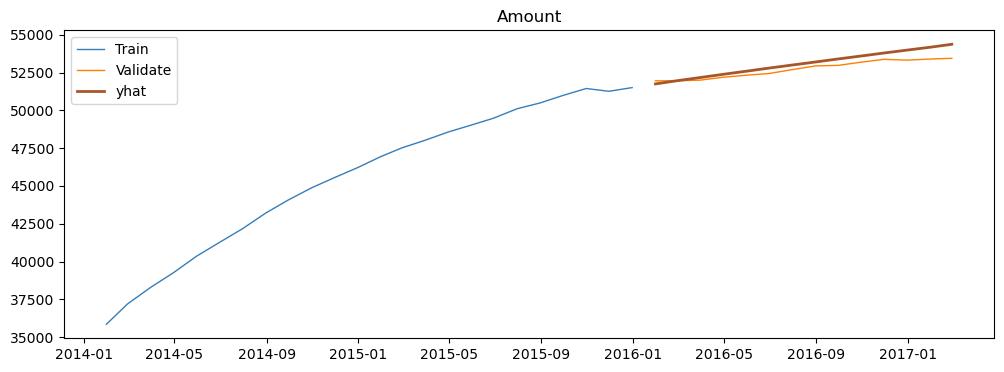

In [36]:
df_model = plot_and_eval('Amount', "Holt's optimized")
df_rmse_model = pd.concat([df_rmse_model,df_model],ignore_index=True)

In [37]:
df_rmse_model

,model_type,target_var,rmse
0,Simple Average,Amount,7181.0
1,7_days_movine_avg,Amount,2050.0
2,Holt's optimized,Amount,456.0


#### Previous Cycle

In [38]:
train = df_resampled[:'2015']
validate = df_resampled['2016']
test = df_resampled['2017']

print(train.shape)
print(validate.shape)
print(test.shape)

(24, 1)
(12, 1)
(12, 1)


#### Make predictions

In [39]:
train.diff(12)

,Amount
Month_Invoiced,
2014-01-31,NaN
2014-02-28,NaN
2014-03-31,NaN
2014-04-30,NaN
2014-05-31,NaN
2014-06-30,NaN
2014-07-31,NaN
2014-08-31,NaN
2014-09-30,NaN


In [40]:
yhat_df = train['2015'] + train.diff(12).mean()
yhat_df

,Amount
Month_Invoiced,
2015-01-31,55033.75
2015-02-28,55608.75
2015-03-31,56113.75
2015-04-30,56648.75
2015-05-31,57113.75
2015-06-30,57573.75
2015-07-31,58193.75
2015-08-31,58583.75
2015-09-30,59073.75


In [41]:
train.loc['2015'].head()

,Amount
Month_Invoiced,
2015-01-31,46945.0
2015-02-28,47520.0
2015-03-31,48025.0
2015-04-30,48560.0
2015-05-31,49025.0


In [42]:
yhat_df.head()

,Amount
Month_Invoiced,
2015-01-31,55033.75
2015-02-28,55608.75
2015-03-31,56113.75
2015-04-30,56648.75
2015-05-31,57113.75


In [43]:
pd.concat([yhat_df.head(1), validate.head(1)])

,Amount
Month_Invoiced,
2015-01-31,55033.75
2016-01-31,51955.00


In [44]:
yhat_df.index = validate.index

Amount -- RMSE: 5192


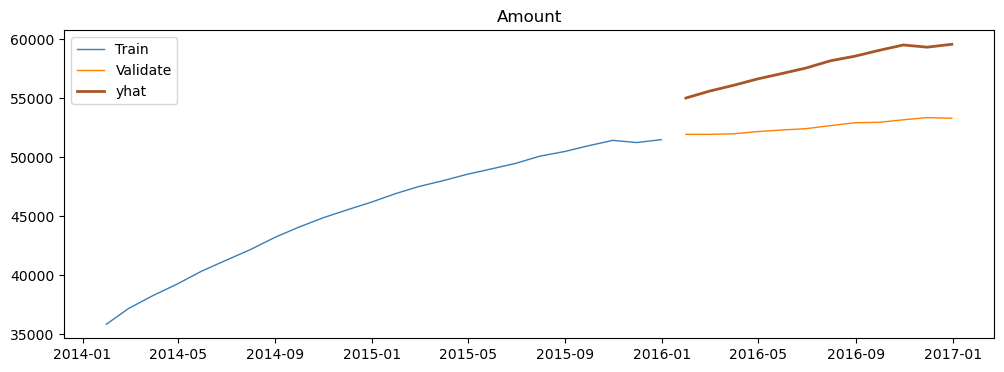

In [45]:
df_model = plot_and_eval('Amount', 'Previous_year')
df_rmse_model = pd.concat([df_rmse_model,df_model],ignore_index=True)

In [46]:
df_rmse_model.sort_values(by='rmse')

,model_type,target_var,rmse
2,Holt's optimized,Amount,456.0
1,7_days_movine_avg,Amount,2050.0
3,Previous_year,Amount,5192.0
0,Simple Average,Amount,7181.0


In [47]:
# doing this in a loop for each column
for col in train.columns:
    model = Holt(train[col], exponential=False, damped=True)
    model = model.fit(optimized=True)
    yhat_values = model.predict(start = validate.index[0],
                              end = validate.index[-1])
    yhat_df[col] = round(yhat_values, 2)

In [48]:
yhat_df = pd.DataFrame({'Amount': model.forecast(validate.shape[0] + test.shape[0])})
yhat_df

,Amount
2016-01-31,51748.618256
2016-02-29,51961.996333
2016-03-31,52173.347323
2016-04-30,52382.690483
2016-05-31,52590.044887
2016-06-30,52795.429429
2016-07-31,52998.862822
2016-08-31,53200.363602
2016-09-30,53399.950129
2016-10-31,53597.640587


In [49]:
validate.head(1)

,Amount
Month_Invoiced,
2016-01-31,51955.0


In [50]:
test.head(1)

,Amount
Month_Invoiced,
2017-01-31,53395.0


In [51]:
yhat_df = yhat_df['2017-01-31':]

In [52]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], color='#377eb8', label='train')
    plt.plot(validate[target_var], color='#ff7f00', label='validate')
    plt.plot(test[target_var], color='#4daf4a',label='test')
    plt.plot(yhat_df[target_var], color='#a65628', label='yhat')
    plt.legend()
    plt.title(target_var)
    plt.show()

In [53]:
rmse_amount = round(mean_squared_error(test['Amount'], yhat_df['Amount'], squared=False),0)
rmse_amount

1645.0

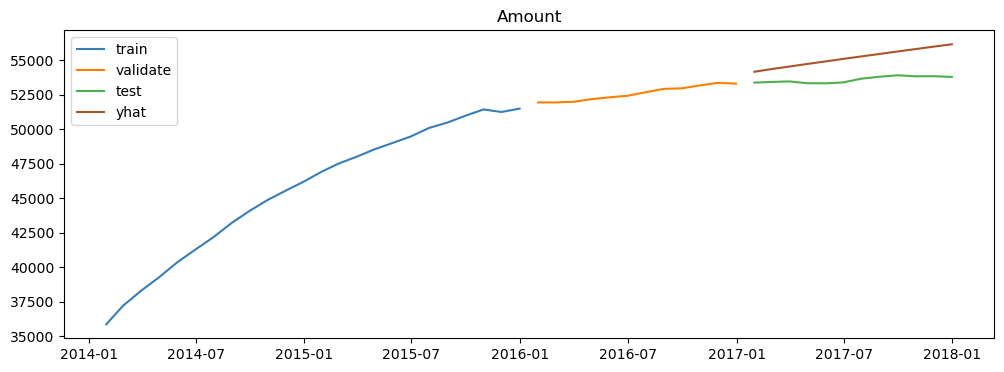

In [54]:
final_plot('Amount')

In [55]:
forecast = pd.DataFrame({'Amount': model.forecast(validate.shape[0] + test.shape[0] +12)})
forecast = forecast['2018':]
forecast

,Amount
2018-01-31,56347.320508
2018-02-28,56517.011010
2018-03-31,56685.089455
2018-04-30,56851.571159
2018-05-31,57016.471290
2018-06-30,57179.804873
2018-07-31,57341.586791
2018-08-31,57501.831784
2018-09-30,57660.554452
2018-10-31,57817.769259


In [56]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], color='#377eb8', label='Train')
    plt.plot(validate[target_var], color='#ff7f00', label='Validate')
    plt.plot(test[target_var], color='#4daf4a', label='Test')
    plt.plot(yhat_df[target_var], color='#a65628', label='yhat')
    plt.plot(forecast[target_var], color='#984ea3', label='Forecast')
    plt.title(target_var)
    plt.legend()
    plt.show()

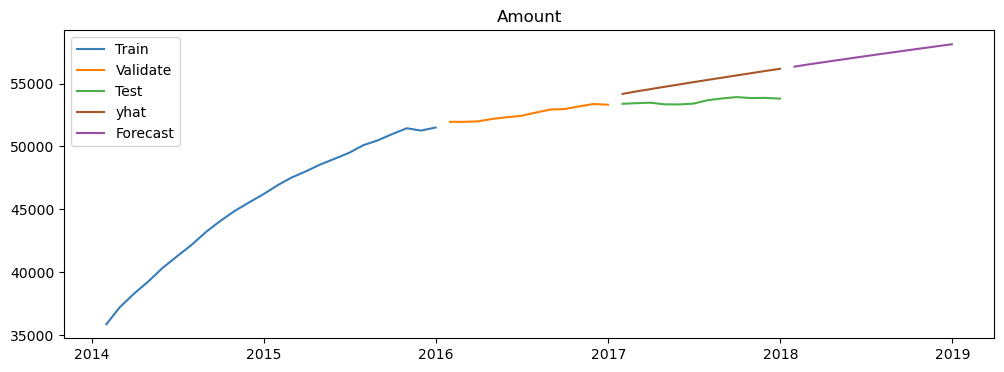

In [57]:
final_plot('Amount')